In [11]:
from dataclasses import dataclass
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [12]:
sns.set_theme(style="whitegrid")

In [13]:
@dataclass
class ModelParams:
    p: int
    d: int
    q: int
    P: int
    D: int
    Q: int
    s: int

    phis: list[float]
    Phis: list[float]
    thetas: list[float]
    Thetas: list[float]

    var: float

    def to_params(self):
        """
        Convert the model parameters to a list of parameters for the SARIMAX model.
        """
        params = []
        params.extend(self.phis)
        params.extend(self.thetas)
        params.extend(self.Phis)
        params.extend(self.Thetas)
        params.append(self.var)

        assert len(params) == self.p + self.q + self.P + self.Q + 1
        return params

    def to_model(self):
        pdq = (self.p, self.d, self.q)
        seasonal_PDQs = (self.P, self.D, self.Q, self.s)

        return SARIMAX(
            [],
            order=pdq,
            seasonal_order=seasonal_PDQs,
        )

    @classmethod
    def from_weights(
        cls,
        phis: list[float] | None = None,
        thetas: list[float] | None = None,
        Phis: list[float] | None = None,
        Thetas: list[float] | None = None,
        d: int = 0,
        D: int = 0,
        s: int = 0,
        var: float = 1.0,
    ):
        """
        Create a ModelParameters instance from a list of parameters.
        """
        if phis is None:
            phis = []
        if thetas is None:
            thetas = []
        if Phis is None:
            Phis = []
        if Thetas is None:
            Thetas = []

        p = len(phis)
        q = len(thetas)
        P = len(Phis)
        Q = len(Thetas)

        return cls(
            p=p,
            d=d,
            q=q,
            P=P,
            D=D,
            Q=Q,
            s=s,
            phis=phis,
            Phis=Phis,
            thetas=thetas,
            Thetas=Thetas,
            var=var,
        )


def plotter(df, params, *, title, n_lags=30):
    """
    Plot the simulated data from a SARIMAX model using a 2-column layout.

    Parameters:
    - model: SARIMAX model instance
    - params: list of parameters for the model
    - n: number of observations to simulate
    - title: title for the overall figure
    """
    # Create a 2×1+1×2 subplot layout
    fig, axes = plt.subplot_mosaic([["ts", "ts"], ["acf", "pacf"]], figsize=(10, 5))

    param_desc = f"(p, d, q) = ({params.p}, {params.d}, {params.q})"
    param_desc += (
        f"\\quad (P, D, Q)_s = ({params.P}, {params.D}, {params.Q})_{{{params.s}}}"
    )
    weights = []
    weights.extend([f"ϕ_{i + 1} = {params.phis[i]}" for i in range(0, params.p)])
    weights.extend([f"θ_{i + 1} = {params.thetas[i]}" for i in range(0, params.q)])
    weights.extend([f"Φ_{i + 1} = {params.Phis[i]}" for i in range(0, params.P)])
    weights.extend([f"Θ_{i + 1} = {params.Thetas[i]}" for i in range(0, params.Q)])
    weights.append(f"σ^2 = {params.var}")

    param_desc += f"\\quad {', '.join(weights)}"
    param_desc = "$" + param_desc + "$"
    title += "\n" + param_desc
    fig.suptitle(title, fontsize=14)

    # Time series
    sns.lineplot(df, x="t", y="y", ax=axes["ts"])
    # axes["ts"].set_title("Time Series")
    axes["ts"].set_xlabel("Discretised Time, $t$")
    axes["ts"].set_ylabel("Observation, $y_t$")

    # ACF plot
    plot_acf(df["y"], lags=n_lags, ax=axes["acf"], alpha=0.05, auto_ylims=True)
    axes["acf"].set_title("Autocorrelation")
    axes["acf"].set_xlabel("Lag, $k$")
    axes["acf"].set_ylabel("$ρ(k)$")

    # PACF plot
    plot_pacf(
        df["y"], lags=n_lags, ax=axes["pacf"], alpha=0.05, zero=False, auto_ylims=True
    )
    axes["pacf"].set_title("Partial Autocorrelation")
    axes["pacf"].set_xlabel("Lag, $k$")
    axes["pacf"].set_ylabel("$φ(k)$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.87)  # Make room for the title
    return fig, axes


def make_data(params, n=1000, burn_in=1000, rng_seed: int = 0):
    """
    Create a SARIMAX model and simulate data.
    """

    model = params.to_model()
    # print(model.param_names)

    # Simulate data
    t = np.arange(n)
    rng = np.random.default_rng(rng_seed)
    y = model.simulate(params.to_params(), n + burn_in, random_state=rng)[burn_in:]

    return pd.DataFrame({"y": y, "t": t})


def make_and_plot(params, n=1000, title="SARIMAX Model Simulation", n_lags=30):
    """
    Create and plot a SARIMAX model with the given parameters.
    """
    df = make_data(params, n)
    fig, axes = plotter(df, params, title=title, n_lags=n_lags)
    return fig
    # plt.savefig(OUTPUT_DIR / f"1_4_{pdq}_{seasonal_PDQs}.png", dpi=DPI_EXPORT)


## 1.1

Text(0, 0.5, 'Observation, $X_t$')

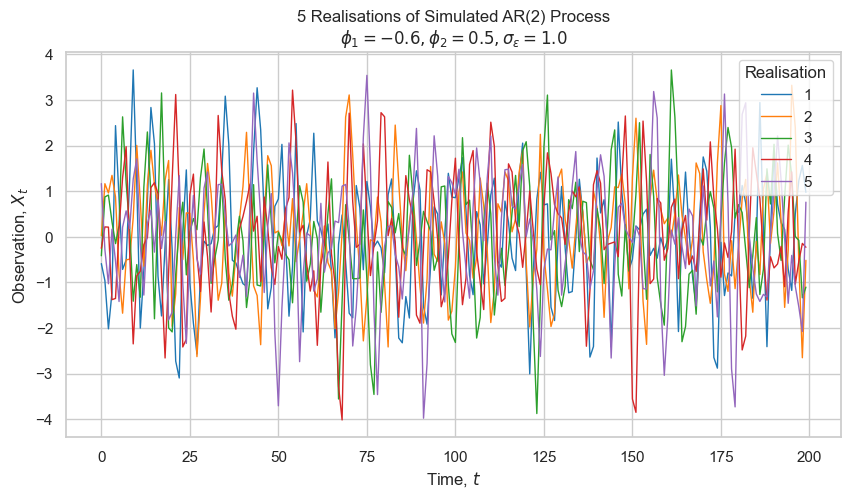

In [26]:
params_1_1 = ModelParams.from_weights(
    phis=[-(-0.6), -(0.5)],  # Note: Sign change
    var=1.0
)

rng = np.random.default_rng(0)
df = pd.DataFrame()

for i in range(5):
    model = params_1_1.to_model()

    # Burn-in period
    BURN_IN = 1000
    n = 200
    t = np.arange(n)
    y = model.simulate(params_1_1.to_params(), n + BURN_IN, random_state=rng)[BURN_IN:]

    df_i = pd.DataFrame({"y": y, "t": t})
    df_i["i"] = i
    df_i["Realisation"] = i + 1
    df = pd.concat([df, df_i], ignore_index=True)

df


fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    df, x="t", y="y", hue="Realisation", palette="tab10", lw=1, ax=ax
)
sns.move_legend(ax, "upper right")
plt.title("5 Realisations of Simulated AR(2) Process\n$ϕ_1 = -0.6, ϕ_2 = 0.5, σ_ε = 1.0$")
plt.xlabel("Time, $t$")
plt.ylabel("Observation, $X_t$")

Text(0, 0.5, '$ρ(k)$')

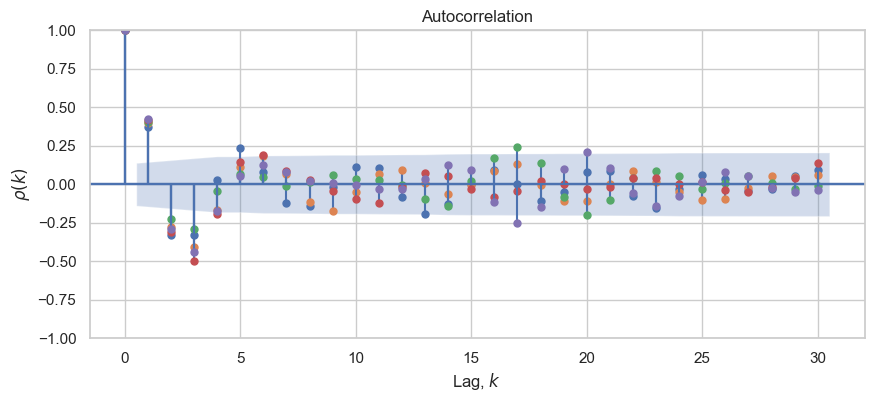

In [50]:
fig, ax1 = plt.subplots(figsize=(10, 4))

N_LAGS = 30
for i, group in df.groupby("i"):
    # ACF plot
    alpha = 0.05 if i == 0 else None
    plot_acf(group["y"], lags=N_LAGS, ax=ax1, alpha=alpha)

ax1.set_title("Autocorrelation")
ax1.set_xlabel("Lag, $k$")
ax1.set_ylabel("$ρ(k)$")

    # plot_pacf(
    #     df["y"], lags=N_LAGS, ax=ax2, alpha=0.05, zero=False,
    # )
    # .set_title("Partial Autocorrelation")
    # .set_xlabel("Lag, $k$")
    # .set_ylabel("$φ(k)$")


## 1.4

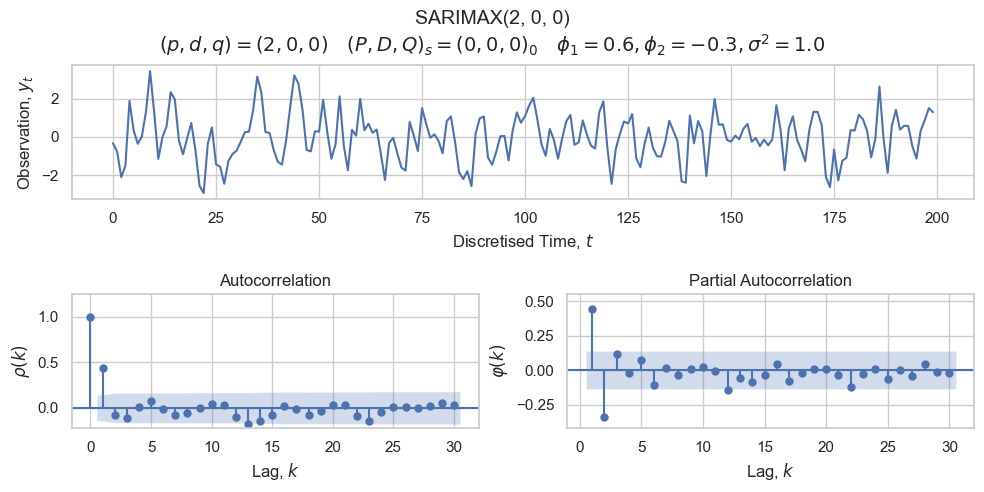

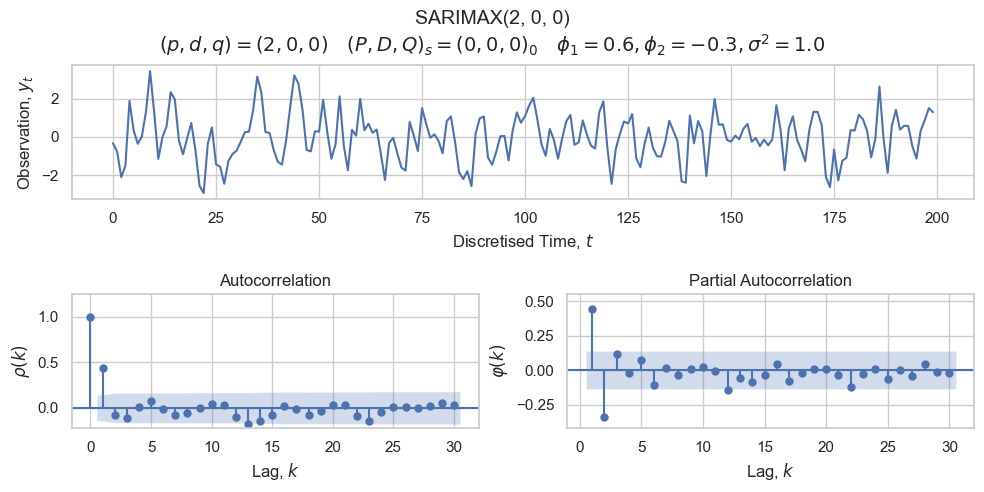

In [15]:
params_1_4 = ModelParams.from_weights(
    phis=[0.6, -0.3],
)
make_and_plot(params_1_4, n=200, title="SARIMAX(2, 0, 0)")